On the night of July 8, 2020, a pointing run was carried out using Binospec's Single-Object Guider. This is the most convenient way to acquire pointing data with the f/5 configuration. It places an imaging camera at the center-of-rotation of the f/5 field-of-view with no extra re-imaging optics or mechanical stages. The pointing data was acquired while keeping the hexapod platform coordinates fixed. Pointing corrections due to tube flexure are performed using the hexapod to help maintain alignment between the optical axes of M1 and M2. The goal here was to measure the flexure using the mount and then use that to update the pointing models for both the mount and hexapod. 

Pointing data acquired with the mount is analyzed using [`tpoint`](http://www.tpointsw.uk/tpoint.htm) and `tpoint` models are implemented directly in the mount software. The MMTO's licensed copy of `tpoint` has been packaged into a Docker container so that it can be run on any platform Docker supports with no other dependencies. Information on how this container is built and run can be found at [https://github.com/MMTObservatory/tpoint_docker](https://github.com/MMTObservatory/tpoint_docker).

The MMTO's mount software implements the standard `tpoint` terms for alt-azimuth telescopes plus two tube flexure terms. The implemented terms are as follows:

| Term    |                 Description                |             Formulae                 |
|:--      |:-------------------------------------------|:------------------------------------|
|  `IA`   | Zero-point offset in azimuth               | $\Delta A = -\mathrm{IA}$          |
|  `IE`   | Zero-point offset in elevation             | $\Delta E = +\mathrm{IE}$          |
| `NPAE`  | Az/El non-perpindicularity                 | $\Delta A \simeq -\mathrm{NPAE} \: \tan(E)$ |
|  `CA`   | Non-perpindicularity between pointing direction and elevation axis | $\Delta A \simeq -\mathrm{CA} \: \sec(E)$ |
|  `AN`   | North-south misalignment of azimuth axis   | $\Delta A \simeq -\mathrm{AN} \: \sin(A) \tan(E)$; $\Delta E \simeq -\mathrm{AN} \: \cos(A)$ |
|  `AW`   | East-west misalignment of azimuth axis     | $\Delta A \simeq -\mathrm{AW} \: \cos(A) \tan(E)$; $\Delta E \simeq +\mathrm{AW} \: \sin(A)$ |
|  `TF`   | Classical tube flexure proportional to $\cos(E)$ | $\Delta E \simeq -\mathrm{TF} \: \cos(E)$ |
|  `TX`   | Empirical tube flexure proportional to $\frac{1}{\tan(E)}$ | $\Delta E \simeq \frac{-\mathrm{TX}}{\tan(E)}$ |


The current pointing model in the mount is based on pointing data taken with f/9 on 5/21/2007:
```
      1     IA         -0.026  +1191.16    1.289
      2     IE         -0.385     -1.81    0.304
      3     NPAE       -0.060     -4.23    1.533
      4     CA         +0.049    +16.71    1.878
      5     AN         +0.019     -1.32    0.103
      6     AW         +0.002    -13.25    0.103
      7     TF         +3.111     +7.65    0.889
      8     TX         -0.829     -2.80    0.291
            Sky RMS =   1.15
            Popn SD =   1.18
```
The `TF` term is actually set to 0 within the mount software since it was expected to be handled by the secondary mirror's hexapod and calibrated with different data, so-called "elcoll" runs. However, the `TX` term is *not* set to 0 within the mount and it should be. This is the first thing we should fix, though fortunately the effect isn't too large at the elevations we observe at.

A total of 73 pointing measurements were collected on 2020-07-08. Fitting the 8-term model to whole data set yields:
```
       coeff       change     value    sigma

  1     IA      +1206.365  +1206.37    6.235
  2     IE        -52.138    -52.14    1.503
  3     NPAE       -1.433     -1.43    6.370
  4     CA         +4.220     +4.22    8.486
  5     AN         +2.093     +2.09    0.373
  6     AW        -12.632    -12.63    0.365
  7     TF        -46.121    -46.12    3.566
  8     TX         -2.970     -2.97    0.950

Sky RMS =   2.71
Popn SD =   2.87
```

However, a significant part of the sky RMS comes from 3 outlier points with residuals of >6". Masking those data points out and re-doing the fit yields:
```
       coeff       change     value    sigma

  1     IA         -0.363  +1206.00    3.302
  2     IE         +0.420    -51.72    0.790
  3     NPAE       -0.728     -2.16    3.366
  4     CA         +0.589     +4.81    4.485
  5     AN         +0.284     +2.38    0.196
  6     AW         +0.271    -12.36    0.193
  7     TF         +6.064    -40.06    1.889
  8     TX         -1.580     -4.55    0.502

Sky RMS =   1.41
Popn SD =   1.50
```

The residuals to this fit show some small cyclical behavior as a function of azimuth. Taking the fit further by adding a harmonic term proportional to $\sin(A)$, `HESA`, and then masking the two points with residuals >2" yields:
```
       coeff       change     value    sigma

  1     IA         -0.692  +1205.27    1.799
  2     IE         +0.899    -50.82    0.433
  3     NPAE       -0.614     -2.80    1.826
  4     CA         +0.842     +5.71    2.436
  5     AN         +0.178     +2.55    0.107
  6     AW         -0.053    -12.58    0.181
  7     TF         +2.719    -37.32    1.044
  8     TX         -0.600     -5.16    0.275
  9     HESA       +0.408     +0.66    0.224

Sky RMS =   0.76
Popn SD =   0.82
```

A sky RMS of 0.76" over 68 stars is really very good! The harmonic component ends up being less than 1" in amplitude so we can lose it and re-do the 8-term fit over the 68 stars to get:
```
       coeff       change     value    sigma

  1     IA         -0.000  +1205.44    1.908
  2     IE         -0.000    -50.85    0.459
  3     NPAE       -0.000     -2.69    1.938
  4     CA         +0.000     +5.49    2.585
  5     AN         -0.000     +2.55    0.114
  6     AW         -0.000    -12.15    0.113
  7     TF         -0.000    -37.46    1.107
  8     TX         +0.000     -5.11    0.291

Sky RMS =   0.81
Popn SD =   0.86
```

Sub-arcsecond sky RMS for the standard 8-term model is as good as we've ever done at the MMTO. This shows that the mount is very capable of sub-arcsecond open-loop pointing accuracy. The remaining challenge is maintaining this performance when the mount and hexapod pointing models are combined. 

Several terms have changed significantly compared to our current pointing model. The flexure difference is expected because the new data was acquired with f/5 and M2 pointing disabled whereas the old data was acquired with f/9 and M2 pointng enabled. The changes in the zero-points are some cause for concern and may be indicative of a misalignment between the M1 and M2 optical axes. There are smaller changes in the axial alignment terms, but big enough to be noticeable. If the old alignment terms are used with the new data with tube flexure terms fixed to new values, these are the results:
```
       coeff       change     value    sigma

  1     IA        -13.888  +1191.56    0.768
  2     IE         -0.296    -51.15    0.534
  3     NPAE                  -4.23
  4     CA                   +16.71
  5     AN                    -1.32
  6     AW                   -13.25
  7     TF                   -37.46
  8     TX                    -5.11

Sky RMS =   4.41
Popn SD =   4.47
```
The zero-point terms had to be allowed to vary due to the 14" offset in azimuth. Allowing the tube flexure terms to vary does not change the results significantly, though. This shows that our current open-loop pointing performance is 4.4" RMS which is pretty far off from where we want to be. 

This biggest component of the difference is the `CA` term. This is a left-right alignment term that can arise from M2 not being properly aligned with the optical axis. It's can also be poorly constrained unless enough observations are taken at high elevation. At lower elevations `CA` and `IA` become degenerate. Looking through past results, there's quite a range of best-fit `CA` values. However, the "zero-order" model from 03/20/2003 that was acquired with a small camera and lens attached directly to the rotator with no secondary in place finds a `CA` value similar to the current data's. In fact, if we ignore `CA`, the sky RMS only increases slightly:
```
       coeff       change     value    sigma

  1     IA         +4.015  +1209.46    0.264
  2     IE         +0.003    -50.85    0.474
  3     NPAE       +4.082     +1.39    0.256
  4     AN         +0.007     +2.56    0.118
  5     AW         +0.005    -12.14    0.116
  6     TF         +0.009    -37.45    1.143
  7     TX         -0.003     -5.12    0.301

Sky RMS =   0.83
Popn SD =   0.88
```

This indicates that `CA` is small and safely ignored both here with f/5 and in the past with no M2 in place. This then suggests our current left-right alignment with f/5 is good and that `CA` should be set to 0 in the mount code. 

The `AW` term measured now is consistent within 1-2" with previous measurements so seems likely unchanged. The `AN` term was historically negative in the past (~-1" to -4"), but is now clearly positive and is the second largest component of our current pointing errors. Pointing runs with different instrument configurations will be needed to see if this change is due to the weight of Binospec being mounted compared to the f/9 instruments used for most past measurements. 

There is still the question of optical alignment along the elevation axis so let's look at what `tpoint` is measuring in terms of tube flexure and how it compares to the model we're currently using within the hexapod control software.

In [1]:
import matplotlib
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

In [2]:
el = np.linspace(15, 90, 100) * u.deg

# for every arcsecond of M2 tilt, translate zc_trans microns to move M2 around zero-coma point
zc_trans = 9.453

# scale factor from arcsec of M2 zero-coma tilt to arcseconds on sky.
zc_sky = 0.3

In [3]:
# best fit tpoint model
best_fit = {}
best_fit['ia'] = +1209.46
best_fit['ie'] = -50.85
best_fit['npae'] = 1.39
best_fit['an'] = 2.56
best_fit['aw'] = -12.14
best_fit['tf'] = -37.45
best_fit['tx'] = -5.12

In [4]:
# convert sky motion to ZC tilt
tiltx_cos_coeff = -1*best_fit['tf'] / zc_sky
tiltx_tan_coeff = -1*best_fit['tx'] / zc_sky

# calculate translations to go with the tilts
y_cos_coeff = zc_trans * tiltx_cos_coeff
y_tan_coeff = zc_trans * tiltx_tan_coeff
tiltx_cos_coeff, y_cos_coeff

(124.83333333333334, 1180.0495)

With the parameters set up, let's compare what our current hexapod pointing model is doing compared to what we have measured with `tpoint` with the hexapod platform fixed in place. The model within the hexapod control system is of the form $\Delta E = a \cos(E) + b \sin(E)$. Plus there is a `TX` term that is still currently implemented in the mount.

305.8693456032505 239.03285737037305


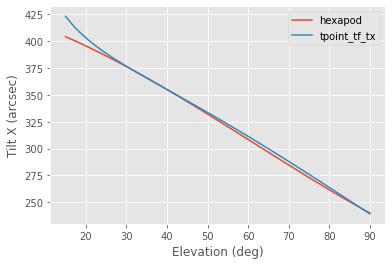

In [5]:
# the cos, sin, and zeropoint coeffs are taken from settings.xml; commanded tiltx from the logs
# the tpoint zeropoint is referenced to an elevation of 0, but the hexapod platform coordinates
# were set for an elevation around 40 deg. the difference between the commanded position and the
# configured zeropoint should account for this.
commanded = 355
zeropoint = 277.3
hex_el = 40 * u.deg
hex_pointing_offset = commanded - zeropoint

# predicted hexapod tiltx as a function of elevation
current_hexapod = 119.6*np.cos(el) - 66.1*np.sin(el) + zeropoint

# there were extra offsets applied by the operator. let's work out the total given the commanded position and the 
# elevation the model was set to.
hex_zp_corr = 355 - 119.6*np.cos(hex_el) + 66.1*np.sin(hex_el) - zeropoint

current_hexapod += hex_zp_corr

# use the tpoint coefficients scaled to hexapod motion. work out zeropoint to match the fact hexapod coordinates
# were configured for el=40: 
tp_zp = commanded - tiltx_cos_coeff * np.cos(hex_el) - tiltx_tan_coeff * np.cos(hex_el)/np.sin(hex_el)
tpoint_model = tiltx_cos_coeff * np.cos(el) + tiltx_tan_coeff * np.cos(el)/np.sin(el) + tp_zp
print(zeropoint+hex_zp_corr, tp_zp)
plt.plot(el, current_hexapod, label="hexapod")
plt.plot(el, tpoint_model, label="tpoint_tf_tx")
plt.ylabel("Tilt X (arcsec)")
plt.xlabel("Elevation (deg)")
plt.legend()
plt.show()

This shows that our current open-loop flexure model is in good agreement with what was measured with the pointing run, certainly in a relative sense. The `TX` term in the mount is also shown to be a fairly small effect, alignment-wise. The difference is the equivalent to 10" of X tilt at an elevation of 30° and much less at higher elevations. 

Ideally, we will want to set `TX` to zero in the mount and handle everything flexure-related with the hexapod. We can implement the hexapod software's current flexure model in `tpoint` by replacing the `TF` and `TX` terms with `HESE` (harmonic elevation error proportional to $\sin(E)$) and `HECE` (harmonic elevation error proportional to $\cos(E)$). If we do this fit to the masked data from before, we get:
```
       coeff       change     value    sigma

  1     IA         -0.000  +1209.45    0.293
  2     IE         -0.002    -12.67    2.971
  3     NPAE       +0.000     +1.41    0.285
  4     AN         -0.000     +2.49    0.130
  5     AW         -0.000    -12.25    0.129
  6     HESE       -0.001    -33.08    2.228
  7     HECE       +0.004    +23.47    2.191

Sky RMS =   0.93
Popn SD =   0.98
```
The RMS of this fit is slightly worse than the `TF`/`TX` model, but still sub-arcsecond. Note also that the remaining three axial misalignment terms are not significantly changed. Even leaving flexure completely out of the fitting gives the same results within the uncertainties for those terms:
```
       coeff       change     value    sigma

  1     IA         -0.000  +1209.44    3.641
  2     IE         -0.000    -19.84    1.401
  3     NPAE       -0.000     +1.45    3.534
  4     AN         -0.000     +2.64    1.616
  5     AW         +0.000    -12.62    1.600

Sky RMS =  11.49
Popn SD =  11.94
```

In [6]:
# define the tpoint harmonic parameters and scale them to hexapod tilts
hese = -33.08
hece = 23.47
tpoint_sin, tpoint_cos = hese/zc_sky, hece/zc_sky
print(tpoint_cos, tpoint_sin)

78.23333333333333 -110.26666666666667


365.94783682809435


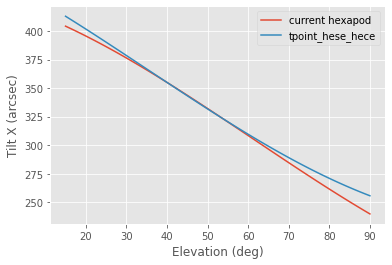

In [7]:
# work out zeropoint to match elevation hexapod platform was set for during pointing run
tp_hex_zp = commanded - tpoint_sin * np.sin(hex_el) - tpoint_cos * np.cos(hex_el)
print(tp_hex_zp)
tpoint_hexapod = tpoint_sin * np.sin(el) + tpoint_cos * np.cos(el) + tp_hex_zp
plt.plot(el, current_hexapod, label="current hexapod")
plt.plot(el, tpoint_hexapod, label="tpoint_hese_hece")
plt.ylabel("Tilt X (arcsec)")
plt.xlabel("Elevation (deg)")
plt.legend()
plt.show()

So the `tpoint` model using `HESE` and `HECE` tracks what we're currently doing reasonably well in a relative sense, but let's look at the residuals and see:

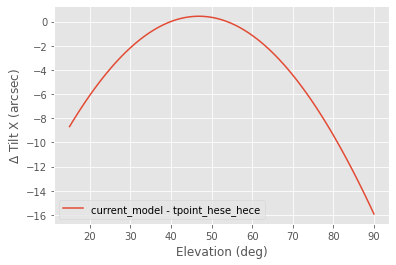

-4.147849588927908


In [8]:
residuals = current_hexapod - tpoint_hexapod
plt.plot(el, residuals, label="current_model - tpoint_hese_hece")
plt.ylabel("$\Delta$ Tilt X (arcsec)")
plt.xlabel("Elevation (deg)")
plt.legend()
plt.show()
print(np.mean(residuals))

The best-fit `TF`/`TX` model matches our current hexapod model more closely than the best-fit `HESE`/`HECE` model. This is curious since the latter is an implementation of our hexapod model in `tpoint`. However, the disagreement is mostly outside of the range of elevation sampled by the Binospec pointing run. The `TF`/`TX` model seems to extrapolate better when fit to data within the elevation range usually sampled by pointing runs (25° to 80°). It's hard to get a lot of pointing data above 80°, for example. Since the observed behavior is very close to linear, it may eventually make more sense to use that, simpler model instead. Here's an example of a `tpoint` fit with a linear change in elevation as a function of elevation:
```
       coeff       change     value    sigma

  1     IA         +0.013  +1209.45    0.290
  2     IE        +31.257    +11.42    0.323
  3     NPAE       -0.040     +1.41    0.282
  4     AN         -0.159     +2.48    0.129
  5     AW         +0.393    -12.23    0.128
  6     PEE1      -38.955    -38.95    0.378

Sky RMS =   0.92
Popn SD =   0.96
```

For now, though, the agreement between the best-fit `TF`/`TX` terms from the latest pointing run and our current hexapod pointing model argues that the current model can be kept as-is for now, modulo any changes to zeropoints.

## Summary

The pointing data collected with Binospec on 2020/07/08 shows that the pointing model used by the MMT is clearly in need of improvement. The currently implemented model has an RMS pointing accuracy of 4.5" with pointing error amplitudes approaching 10" in parts of the sky. Updating the mount's active pointing model based on this new data promises to improve this to 1" RMS or better across the entire sky. The biggest component of the current pointing errors is a large `CA` term that could be due to an M2 misalignment at the time the old pointing data was taken. The current pointing data favor a small `CA` term and setting it to 0 doesn't affect the RMS of the `tpoint` fit significantly. The mount code shold be updated to set it to 0. The other term that has changed significantly is a north-south shift of the elevation axis, `AN`. It appears to have shifted ~5" to the north. More pointing data with different instrument combinations are needed to test if this is a shift within the mount or foundation or is due to Binospec's weight. 

The flexure model we are currently using is working reasonably well. Its behavior in the `TILTX` axis closely matches the best-fit `tpoint` model that uses a combination of $\cos(E)$ and $\cot(E)$ terms. Implementing a clone of our hexapod model, a combination of $\cos(E)$ and $\sin(E)$, in `tpoint` yields a slightly worse fit and worse agreement on-sky compared to our current hexapod model. The flexure behavior as a function of elevation is actually very close to linear. Implementing and fitting such a linear term in `tpoint` yields a fit that works just as well as the more complicated trigonometric combinations. Future pointing runs should try to include more targets at elevations above 80° to help differentiate between linear and trigonometric models. 

An outstanding issue is that there is a degeneracy between the zeropoints in the hexapod and mount pointing models. This highlights the need to re-visit doing a "zero-order" pointing run using an alignment telescope mounted on the rotator at the center of rotation. This was last done in 2003 as far as can be told from the notes in the mount code. The degeneracy is most acute in elevation. In azimuth, any significant side-to-side misalignment between M1 and M2 would manifest in the `CA` term and we seem to be doing well there. Enough of a "zero-order" pointing run to nail down that actual value of `IE` is for the mount would be a big help. Doing a full run with > 50 stars to verify the other terms would be ideal as a sanity check. 

For now, I think the best way to go is to use the `tpoint` fit that leaves the flexure model out and implement those values in the mount:
```
       coeff       change     value    sigma

  1     IA         -0.000  +1209.44    3.641
  2     IE         -0.000    -19.84    1.401
  3     NPAE       -0.000     +1.45    3.534
  4     AN         -0.000     +2.64    1.616
  5     AW         +0.000    -12.62    1.600

Sky RMS =  11.49
Popn SD =  11.94
```
This way `IE` doesn't include offsets for the zeropoints of the trigonometric `TF` or `TX` terms. They should be handled by the hexapod's model. This is offset by about -20" from the previous value, but is closer to the value of about -30" that was determined for the old "zero-order" model. The remaining mount-specific terms are independent of whether flexure is included or not. 

The hexapod open-loop terms should be changed as follows:

* Keep the sin/cos terms for `TILTX` unchanged since they closely match what `tpoint` measures.
* Adjust the zeropoint for `TILTX` to reflect the platform coordinates used for this pointing run. I calculate the new value to be 305.9. 
* Adjust the sin/cos terms for `Y` so that they are scaled versions of the `TILTX` coefficients to reflect pure zero-coma motion. See output of following cell for the new values.
* Set the sin/cos coefficients for `X` and `TILTY` to 0 to remove any elevation dependence. There should not be any and none is observed in the pointing data. The zeropoint terms should be set to the values used during the pointing run since good side-to-side collimation is verified by the low values of `CA` and `NPAE` favored by the data.

The OSS is designed so that flexure is supposed to move M2 around its zero-coma point as much as possible. These proposed changes will make the hexapod's open-loop model a zero-coma flexure model. There may be some residual tilt as a function of elevation that would appear as coma at the focal plane. As shown in the following cells, there is residual tilt between the zero-coma model and the current one. However, this residual tilt equates to change of 466.5 nm of wavefront coma between the maximum residual at an elevation of 50 deg and the minimum at 90 deg. This is well within the range of what the wavefront sensors can handle and would only generate a noticable degradation in image quality under the best conditions. Implementing a zero-coma flexure model in the hexapod will make it a lot easier to data-mine WFS data to look for systematic trends in coma. It will also help in diagnosing problems with M2 support systems, e.g. immediately look there if large amounts of coma are suddenly present.

A pull request for the changes to the hexapod settings can be found at https://github.com/MMTObservatory/settings/pull/1. A pull request for the changes to the mount code can be found at https://github.com/MMTObservatory/mount/pull/1. 


In [9]:
# we've shown that the hexapod open-loop model for TILTX tracks the flexure that tpoint measures pretty  closely. so let's fix the model
# for Y so that the hexapod flexure model works purely in zero-coma motion. 
current_hexapod = 119.6*np.cos(el) - 66.1*np.sin(el) + zeropoint
transy_cos = 119.6 * zc_trans
transy_sin = -66.1 * zc_trans
print(f"Y cos coeff = {transy_cos}, Y sin coeff = {transy_sin}")
new_y_zp = 3150 - transy_cos * np.cos(hex_el) - transy_sin * np.sin(hex_el)
print(f"new Y zeropoint = {new_y_zp}")

Y cos coeff = 1130.5787999999998, Y sin coeff = -624.8432999999999
new Y zeropoint = 2685.5679239875267


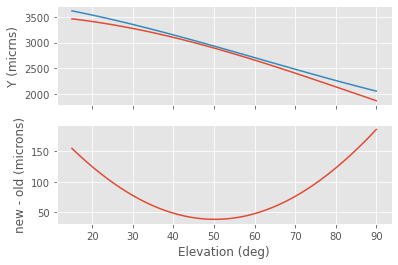

In [27]:
# compare the new Y model that is scaled from the TX model to make a purely zero-coma flexure model
# to the old model to see how much residual tilt
tx_model = 119.6*np.cos(el) - 66.1*np.sin(el)
y_old_model = 1538*np.cos(el) - 135.8*np.sin(el) + 2010.7
y_new_model = 1130.58*np.cos(el) - 624.84*np.sin(el) + 2685.6
model_diff = y_new_model - y_old_model
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(el, y_old_model)
ax[0].plot(el, y_new_model)
ax[0].set_ylabel("Y (micrns)")
ax[1].set_xlabel("Elevation (deg)")
ax[1].plot(el, model_diff)
ax[1].set_ylabel("new - old (microns)")
plt.show()

In [26]:
diff_trans = model_diff.max() - model_diff.min()
print(f"There is range of {diff_trans:.2f} um of residual translation between the zero-coma model and the old one.")
diff_cc_tilt = diff_trans / 24.97  # 24.97 um of trans per arcsec of center-of-curvature tilt
diff_coma = 79 * diff_cc_tilt  # 79 nm of wavefront coma per arcsec of center-of-curvature tilt
print(f"This range of translation equates to {diff_cc_tilt:.2f} arcsec of tilt and {diff_coma:.1f} nm of coma")

There is range of 147.46 um of residual translation between the zero-coma model and the old one.
This range of translation equates to 5.91 arcsec of tilt and 466.5 nm of coma
